In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [4]:
stock_code = pd.read_csv('./data/data.csv', encoding='cp949')

In [9]:
stock_code = {i:j for i,j in zip(stock_code.종목코드.map(lambda x : '{:06d}'.format(x)), stock_code.종목명)}

In [287]:
from FinanceDataReader import data as fdr

KOSPI = fdr.DataReader('KS11','2010')
DJI = fdr.DataReader('DJI','2010')
CSI = fdr.DataReader('CSI300','2010')
SP = fdr.DataReader ('SPX','2010')
FTSE = fdr.DataReader ('UK100','2010')
N225 = fdr.DataReader ('JP225','2010')
US_exchange = fdr.DataReader ('USD/KRW','2010')
CH_exchange = fdr.DataReader ('CNY/KRW','2010')
JP_cxchange = fdr.DataReader ('JPY/KRW','2010')
gold = fdr.DataReader ('GC','2010')
wti = fdr.DataReader('WTI/USD', '2010')

In [288]:
others = [KOSPI,DJI,CSI,SP,FTSE,N225,US_exchange,CH_exchange,JP_cxchange,gold,wti]

In [289]:
import pickle
with open('raw_data_20181008.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

copy_keys = list(raw_data.keys())
for stock in copy_keys:
    if len(raw_data[stock].loc[:'2013-01-01']) < 1:
        del raw_data[stock]
del copy_keys

# stock에서 Volume==0인 index, stock에서 제외
for key, df in raw_data.items():
    raw_data[key] = df.drop(df.index[np.where(df.Volume==0)[0]], axis=0)
    del df['Adj Close']
    raw_data[key]['Volume'] = df.Volume / 1e7

In [290]:
copy_keys = list(raw_data.keys())
for stock in copy_keys:
    if len(raw_data[stock].loc[:'2010-02-01']) < 1:
        del raw_data[stock]
del copy_keys

In [291]:
len(raw_data)

167

# Generate Columns

In [2]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['Close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['Close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.Close - df.Low.rolling(n).min()) / 
                                      (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df
    
def get_RSI(df, n=14):
    U = np.where(df['Close'].diff(1)>0, df['Close'].diff(1), 0)
    D = np.where(df['Close'].diff(1)<0, df['Close'].diff(1)*(-1), 0)
    
    AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
    AD = pd.Series(D).rolling(window=n, min_periods=n).mean()
    
    RSI = AU.div(AD+AU) * 100
    df['RSI_{}'.format(n)] = RSI.values
    return df
    
def get_BolingerBand(df, n=20, k=2):
    df = df.assign(BolingerCenter = df['Close'].rolling(window=n).mean())
    df = df.assign(Bol_upper = df['Close'].rolling(window=n).mean() + k*df['Close'].rolling(window=n).std())
    df = df.assign(Bol_lower = df['Close'].rolling(window=n).mean() - k*df['Close'].rolling(window=n).std())
    return df

def get_SMA(df, window):
    df['close_ma_{}'.format(window)] = df['Close'].rolling(window).mean()
    return df
    
def get_EMA(df, window):
    df['close_ema_{}'.format(window)] = df['Close'].ewm(span=window).mean()
    return df
    
def get_RoC(df, periods):
    df['roc_{}'.format(periods)] = df['Close'].pct_change(periods=periods)
    return df
    
def get_CV(df, window):
    df['his_vol_{}'.format(window)] = np.log(df['Close'] / df['Close'].shift(1)).rolling(window).std()*(252**0.5)
    return df
    
def get_WilliamR(df, n):
    W_R = -100 * ((df.High.rolling(n).max() - df.Close) / (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['WR_{}'.format(n)] = W_R
    return df
    
def get_CCI(df, window):
    TP = (df.Close + df.Low + df.High) / 3
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['CCI_{}'.format(window)] = CCI
    return df
    
def get_DI(df, window):
    df['DI_{}'.format(window)] = 100 * ((df.Close - df.Close.rolling(window).mean()) / df.Close.rolling(window).mean())
    return df

def get_VPT(df):
    df['VPT'] = ((test.Close.diff(1) / test.Close) * test.Volume).cumsum()
    return df
    
def get_MA_diff(df, window):
    df['ma_diff_{}'.format(window)] = df['Close'].rolling(window).mean() - df['Close'].shift(window).rolling(window).mean()
    return df

def get_MA_n_diff(df, n, window):
    df['ma_{}_diff_{}'.format(n, window)] = df['Close'].rolling(window).mean() - df['Close'].rolling(window+n).mean()
    return df
    
def get_OBV(df):
    df['OBV'] = (np.sign(df['Close'].diff(1).fillna(0)) * df['Volume']).cumsum()
    return df

In [293]:
import time
for key, df in raw_data.items():
    start = time.time()
    print(key)
    for window in range(1, 91):
        raw_data[key] = get_SMA(df, window)
        raw_data[key] = get_EMA(df, window)
    n = 10
    for window in range(1, 91):
        raw_data[key] = get_MA_diff(df, window)
        raw_data[key] = get_MA_n_diff(df, n, window)
    for window in range(12, 91):
        raw_data[key] = get_CV(df, window)
    for periods in range(1, 11):
        raw_data[key] = get_RoC(df, periods)
    for n in range(3, 91):
        raw_data[key] = get_RSI(df, n)
        raw_data[key] = get_Stochastic(df, n)
        raw_data[key] = get_WilliamR(df, n)
    raw_data[key] = get_CCI(df, 20)
    for window in [5,10]:
        raw_data[key] = get_DI(df, window)
    raw_data[key] = get_MACD(df)
    raw_data[key] = get_OBV(df)
    print('Done {:.2f} sec'.format(time.time() - start))

AK홀딩스
Done 1.95 sec
CJ
Done 1.93 sec
CJ CGV
Done 1.93 sec
CJ대한통운
Done 1.91 sec
CJ제일제당
Done 1.93 sec
DB손해보험
Done 1.91 sec
DB하이텍
Done 1.92 sec
GKL
Done 1.93 sec
GS
Done 1.92 sec
GS건설
Done 1.92 sec
HDC
Done 1.94 sec
JW중외제약
Done 1.90 sec
JW홀딩스
Done 1.90 sec
KB금융
Done 1.90 sec
KCC
Done 1.91 sec
KT
Done 1.91 sec
KT&G
Done 1.91 sec
LF
Done 1.90 sec
LG
Done 1.91 sec
LG디스플레이
Done 1.90 sec
LG상사
Done 1.91 sec
LG생활건강
Done 1.91 sec
LG유플러스
Done 1.90 sec
LG이노텍
Done 1.90 sec
LG전자
Done 1.91 sec
LG하우시스
Done 1.91 sec
LG화학
Done 1.91 sec
LS
Done 1.90 sec
LS산전
Done 1.92 sec
NAVER
Done 1.91 sec
NH투자증권
Done 2.01 sec
OCI
Done 2.25 sec
POSCO
Done 2.33 sec
S&T모티브
Done 2.14 sec
S-Oil
Done 2.63 sec
SBS
Done 2.21 sec
SK
Done 2.25 sec
SKC
Done 2.04 sec
SK네트웍스
Done 1.93 sec
SK디스커버리
Done 1.93 sec
SK이노베이션
Done 1.92 sec
SK텔레콤
Done 1.93 sec
SK하이닉스
Done 1.93 sec
SPC삼립
Done 1.90 sec
강원랜드
Done 1.91 sec
고려아연
Done 1.92 sec
고려제강
Done 2.07 sec
금호석유
Done 2.52 sec
금호타이어
Done 2.55 sec
기아차
Done 2.58 sec
기업은행
Done 2.37 sec
남양유업
Done

In [294]:
import time
for df in others:
    start = time.time()
    for window in range(1, 91):
        df = get_SMA(df, window)
        df = get_EMA(df, window)
    n = 10
    for window in range(1, 91):
        df = get_MA_diff(df, window)
        df = get_MA_n_diff(df, n, window)
    for window in range(12, 91):
        df = get_CV(df, window)
    for periods in range(1, 11):
        df = get_RoC(df, periods)
    for n in range(3, 91):
        df = get_RSI(df, n)
        df = get_Stochastic(df, n)
        df = get_WilliamR(df, n)
    df = get_CCI(df, 20)
    for window in [5,10]:
        df = get_DI(df, window)
    df = get_MACD(df)
#     df = get_OBV(df)
    print('Done {:.2f} sec'.format(time.time() - start))

Done 1.94 sec
Done 1.94 sec
Done 1.94 sec
Done 1.95 sec
Done 1.95 sec
Done 1.93 sec
Done 1.94 sec
Done 1.94 sec
Done 1.94 sec
Done 1.95 sec
Done 1.96 sec


In [295]:
raw_data['삼성전자'].dropna()

,Open,High,Low,Close,Adj Close,Volume,close_ma_1,close_ema_1,close_ma_2,close_ema_2,...,sto_K_90,sto_D_90,WR_90,CCI_20,DI_5,DI_10,MACD,MACDSignal,MACDDiff,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-17,15240.0,15560.0,15160.0,15460.0,8.292887,2.236930,15460.0,15460.0,15300.0,15357.595191,...,35.576923,25.320513,-64.423077,5.649718,1.257532,0.677260,-125.482269,-142.045887,16.563617,-12.315485
2010-09-20,15480.0,15600.0,15400.0,15600.0,8.367985,1.480755,15600.0,15600.0,15530.0,15519.198397,...,42.307692,32.692308,-57.692308,74.867122,1.907499,1.588955,-94.284577,-132.493625,38.209048,-10.834730
2010-09-24,15580.0,15600.0,15160.0,15240.0,8.174877,3.276680,15240.0,15240.0,15420.0,15333.066132,...,25.000000,34.294872,-75.000000,-10.465986,-0.496213,-0.418191,-97.485399,-125.491980,28.006581,-14.111410
2010-09-27,15300.0,15360.0,15040.0,15100.0,8.099781,2.510715,15100.0,15100.0,15170.0,15177.688711,...,18.269231,28.525641,-81.730769,-84.729064,-1.358767,-1.126244,-110.050304,-122.403644,12.353341,-16.622125
2010-09-28,15100.0,15120.0,14900.0,14900.0,7.992498,2.331570,14900.0,14900.0,15000.0,14992.562904,...,8.653846,17.307692,-91.346154,-156.067588,-2.359109,-2.295082,-134.594873,-124.841890,-9.752983,-18.953695
2010-09-29,15060.0,15500.0,15000.0,15440.0,8.282159,3.534805,15440.0,15440.0,15170.0,15290.854301,...,34.615385,20.512821,-65.384615,1.557632,1.206083,1.166295,-109.214207,-121.716354,12.502146,-15.418890
2010-09-30,15440.0,15580.0,15340.0,15540.0,8.335800,1.685550,15540.0,15540.0,15490.0,15456.951434,...,39.423077,27.564103,-60.576923,83.607843,1.941748,1.728201,-80.107260,-113.394535,33.287275,-13.733340
2010-10-01,15440.0,15560.0,15380.0,15540.0,8.335800,1.480575,15540.0,15540.0,15540.0,15512.317145,...,39.423077,37.820513,-60.576923,77.904328,1.542081,1.502286,-56.389769,-101.993582,45.603813,-13.733340
2010-10-04,15600.0,15620.0,15480.0,15600.0,8.367985,1.283535,15600.0,15600.0,15570.0,15570.772382,...,39.393939,39.413364,-60.606061,100.294985,1.272397,1.588955,-32.378748,-88.070615,55.691867,-12.449805


In [296]:
for key, df in raw_data.items():
    print(key)
    for i in range(1, 91):
        df['Y1_{:02}'.format(i)] = df['Close'].shift(-1*i) - df['Close']
        df['Y2_{:02}'.format(i)] = df['Close'].shift(-1*i) - df['Close'].rolling(i).mean()
        df['Y3_{:02}'.format(i)] = df['Close'].shift(-1*i).rolling(i).mean() - df['Close'].rolling(i).mean()

AK홀딩스
CJ
CJ CGV
CJ대한통운
CJ제일제당
DB손해보험
DB하이텍
GKL
GS
GS건설
HDC
JW중외제약
JW홀딩스
KB금융
KCC
KT
KT&G
LF
LG
LG디스플레이
LG상사
LG생활건강
LG유플러스
LG이노텍
LG전자
LG하우시스
LG화학
LS
LS산전
NAVER
NH투자증권
OCI
POSCO
S&T모티브
S-Oil
SBS
SK
SKC
SK네트웍스
SK디스커버리
SK이노베이션
SK텔레콤
SK하이닉스
SPC삼립
강원랜드
고려아연
고려제강
금호석유
금호타이어
기아차
기업은행
남양유업
남해화학
넥센타이어
녹십자
녹십자홀딩스
농심
대교
대덕전자
대림산업
대상
대우건설
대우조선해양
대웅제약
대한유화
대한항공
동국제강
동서
동아쏘시오홀딩스
동양
동원F&B
동원시스템즈
두산
두산인프라코어
두산중공업
락앤락
롯데쇼핑
롯데정밀화학
롯데지주
롯데칠성
롯데케미칼
롯데푸드
메리츠종금증권
무학
미래에셋대우
보령제약
부광약품
빙그레
삼성SDI
삼성엔지니어링
삼성전기
삼성전자
삼성중공업
삼성증권
삼성카드
삼성화재
삼양사
삼양홀딩스
세방전지
세아베스틸
세아제강
셀트리온
신세계
신한지주
쌍용양회
아모레G
아모레퍼시픽
아이에스동서
에스엘
에스원
엔씨소프트
영원무역
영진약품
영풍
오뚜기
오리온홀딩스
우리은행
유니드
유한양행
일양약품
제일기획
카카오
코오롱인더
코웨이
태광산업
팜스코
팬오션
포스코대우
풍산
하나금융지주
하이트진로
한국가스공사
한국금융지주
한국단자
한국쉘석유
한국전력
한국타이어월드와이드
한미사이언스
한샘
한섬
한세실업
한솔케미칼
한온시스템
한올바이오파마
한일시멘트
한전KPS
한전기술
한진중공업
한화
한화에어로스페이스
한화케미칼
현대건설
현대그린푸드
현대글로비스
현대리바트
현대모비스
현대미포조선
현대백화점
현대엘리베이
현대제철
현대중공업
현대차
현대해상
호텔신라
효성
후성
휴켐스


In [297]:
import pickle
store = (raw_data, others)
with open('data_20190106.pickle', 'wb') as handle:
    pickle.dump(store, handle, pickle.HIGHEST_PROTOCOL)

In [4]:
import pickle
with open('data_20190106.pickle', 'rb') as handle:
    store = pickle.load(handle)
raw_data, others = store

In [5]:
for key, df in raw_data.items():
    raw_data[key] = df.dropna().loc['2010-10-01':'2018-08-01']
for df in others:
    df = df.dropna().loc['2010-10-01':'2018-08-01']

In [7]:
y_li = [col for col in raw_data['삼성전자'] if col.find('Y') != -1]

prepare_training = {}
for key, df in raw_data.items():
#     if key != '삼성전자':
#         continue
    print(key)
    target_set = {}
    for y in y_li:
        col_set = {}
        for col_name in ['sto_K','sto_D','RSI','close_ma','close_ema','roc','his_vol','WR',
                         'CCI','DI','ma_diff','MACD','MACDSignal','MACDDiff','OBV']:
            corr_ = abs(df[[col for col in df if (col.find(col_name) != -1)|
                    (col.find(y) != -1)]].corr()[y]).sort_values(ascending=False)
            col_set[corr_.index[1]] = corr_.iloc[1]
        target_set[y] = col_set
    prepare_training[key] = target_set

AK홀딩스
CJ
CJ CGV
CJ대한통운
CJ제일제당
DB손해보험
DB하이텍
GKL
GS
GS건설
HDC
JW중외제약
JW홀딩스
KB금융
KCC
KT
KT&G
LF
LG
LG디스플레이
LG상사
LG생활건강
LG유플러스
LG이노텍
LG전자
LG하우시스
LG화학
LS
LS산전
NAVER
NH투자증권
OCI
POSCO
S&T모티브
S-Oil
SBS
SK
SKC
SK네트웍스
SK디스커버리
SK이노베이션
SK텔레콤
SK하이닉스
SPC삼립
강원랜드
고려아연
고려제강
금호석유
금호타이어
기아차
기업은행
남양유업
남해화학
넥센타이어
녹십자
녹십자홀딩스
농심
대교
대덕전자
대림산업
대상
대우건설
대우조선해양
대웅제약
대한유화
대한항공
동국제강
동서
동아쏘시오홀딩스
동양
동원F&B
동원시스템즈
두산
두산인프라코어
두산중공업
락앤락
롯데쇼핑
롯데정밀화학
롯데지주
롯데칠성
롯데케미칼
롯데푸드
메리츠종금증권
무학
미래에셋대우
보령제약
부광약품
빙그레
삼성SDI
삼성엔지니어링
삼성전기
삼성전자
삼성중공업
삼성증권
삼성카드
삼성화재
삼양사
삼양홀딩스
세방전지
세아베스틸
세아제강
셀트리온
신세계
신한지주
쌍용양회
아모레G
아모레퍼시픽
아이에스동서
에스엘
에스원
엔씨소프트
영원무역
영진약품
영풍
오뚜기
오리온홀딩스
우리은행
유니드
유한양행
일양약품
제일기획
카카오
코오롱인더
코웨이
태광산업
팜스코
팬오션
포스코대우
풍산
하나금융지주
하이트진로
한국가스공사
한국금융지주
한국단자
한국쉘석유
한국전력
한국타이어월드와이드
한미사이언스
한샘
한섬
한세실업
한솔케미칼
한온시스템
한올바이오파마
한일시멘트
한전KPS
한전기술
한진중공업
한화
한화에어로스페이스
한화케미칼
현대건설
현대그린푸드
현대글로비스
현대리바트
현대모비스
현대미포조선
현대백화점
현대엘리베이
현대제철
현대중공업
현대차
현대해상
호텔신라
효성
후성
휴켐스


In [8]:
with open('prepare_data_20190107.pickle', 'wb') as handle:
    pickle.dump(prepare_training, handle, pickle.HIGHEST_PROTOCOL)

In [9]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [10]:
stock_dataset = {}
for stock, data in prepare_training.items():
    print(stock)
    dataset = {}
    for y, X in data.items():
        dataset[y] = (raw_data[stock][list(X.keys())], raw_data[stock][y])
    stock_dataset[stock] = dataset

AK홀딩스
CJ
CJ CGV
CJ대한통운
CJ제일제당
DB손해보험
DB하이텍
GKL
GS
GS건설
HDC
JW중외제약
JW홀딩스
KB금융
KCC
KT
KT&G
LF
LG
LG디스플레이
LG상사
LG생활건강
LG유플러스
LG이노텍
LG전자
LG하우시스
LG화학
LS
LS산전
NAVER
NH투자증권
OCI
POSCO
S&T모티브
S-Oil
SBS
SK
SKC
SK네트웍스
SK디스커버리
SK이노베이션
SK텔레콤
SK하이닉스
SPC삼립
강원랜드
고려아연
고려제강
금호석유
금호타이어
기아차
기업은행
남양유업
남해화학
넥센타이어
녹십자
녹십자홀딩스
농심
대교
대덕전자
대림산업
대상
대우건설
대우조선해양
대웅제약
대한유화
대한항공
동국제강
동서
동아쏘시오홀딩스
동양
동원F&B
동원시스템즈
두산
두산인프라코어
두산중공업
락앤락
롯데쇼핑
롯데정밀화학
롯데지주
롯데칠성
롯데케미칼
롯데푸드
메리츠종금증권
무학
미래에셋대우
보령제약
부광약품
빙그레
삼성SDI
삼성엔지니어링
삼성전기
삼성전자
삼성중공업
삼성증권
삼성카드
삼성화재
삼양사
삼양홀딩스
세방전지
세아베스틸
세아제강
셀트리온
신세계
신한지주
쌍용양회
아모레G
아모레퍼시픽
아이에스동서
에스엘
에스원
엔씨소프트
영원무역
영진약품
영풍
오뚜기
오리온홀딩스
우리은행
유니드
유한양행
일양약품
제일기획
카카오
코오롱인더
코웨이
태광산업
팜스코
팬오션
포스코대우
풍산
하나금융지주
하이트진로
한국가스공사
한국금융지주
한국단자
한국쉘석유
한국전력
한국타이어월드와이드
한미사이언스
한샘
한섬
한세실업
한솔케미칼
한온시스템
한올바이오파마
한일시멘트
한전KPS
한전기술
한진중공업
한화
한화에어로스페이스
한화케미칼
현대건설
현대그린푸드
현대글로비스
현대리바트
현대모비스
현대미포조선
현대백화점
현대엘리베이
현대제철
현대중공업
현대차
현대해상
호텔신라
효성
후성
휴켐스


In [11]:
stock_train = {}
stock_test = {}
for stock, dataset in stock_dataset.items():
    print(stock)
    train_set = {}
    test_set = {}
    for y, data in dataset.items():
        std = StandardScaler()
        std.fit(data[0].iloc[:int(0.8*len(data[0]))].values)
        train_set[y] = (std.transform(data[0].iloc[:int(0.8*len(data[0]))].values), 
                        data[1].iloc[:int(0.8*len(data[1]))])
        test_set[y] = (std.transform(data[0].iloc[int(0.8*len(data[0])):].values), 
                       data[1].iloc[int(0.8*len(data[1])):])
    stock_train[stock] = train_set
    stock_test[stock] = test_set

AK홀딩스
CJ
CJ CGV
CJ대한통운
CJ제일제당
DB손해보험
DB하이텍
GKL
GS
GS건설
HDC
JW중외제약
JW홀딩스
KB금융
KCC
KT
KT&G
LF
LG
LG디스플레이
LG상사
LG생활건강
LG유플러스
LG이노텍
LG전자
LG하우시스
LG화학
LS
LS산전
NAVER
NH투자증권
OCI
POSCO
S&T모티브
S-Oil
SBS
SK
SKC
SK네트웍스
SK디스커버리
SK이노베이션
SK텔레콤
SK하이닉스
SPC삼립
강원랜드
고려아연
고려제강
금호석유
금호타이어
기아차
기업은행
남양유업
남해화학
넥센타이어
녹십자
녹십자홀딩스
농심
대교
대덕전자
대림산업
대상
대우건설
대우조선해양
대웅제약
대한유화
대한항공
동국제강
동서
동아쏘시오홀딩스
동양
동원F&B
동원시스템즈
두산
두산인프라코어
두산중공업
락앤락
롯데쇼핑
롯데정밀화학
롯데지주
롯데칠성
롯데케미칼
롯데푸드
메리츠종금증권
무학
미래에셋대우
보령제약
부광약품
빙그레
삼성SDI
삼성엔지니어링
삼성전기
삼성전자
삼성중공업
삼성증권
삼성카드
삼성화재
삼양사
삼양홀딩스
세방전지
세아베스틸
세아제강
셀트리온
신세계
신한지주
쌍용양회
아모레G
아모레퍼시픽
아이에스동서
에스엘
에스원
엔씨소프트
영원무역
영진약품
영풍
오뚜기
오리온홀딩스
우리은행
유니드
유한양행
일양약품
제일기획
카카오
코오롱인더
코웨이
태광산업
팜스코
팬오션
포스코대우
풍산
하나금융지주
하이트진로
한국가스공사
한국금융지주
한국단자
한국쉘석유
한국전력
한국타이어월드와이드
한미사이언스
한샘
한섬
한세실업
한솔케미칼
한온시스템
한올바이오파마
한일시멘트
한전KPS
한전기술
한진중공업
한화
한화에어로스페이스
한화케미칼
현대건설
현대그린푸드
현대글로비스
현대리바트
현대모비스
현대미포조선
현대백화점
현대엘리베이
현대제철
현대중공업
현대차
현대해상
호텔신라
효성
후성
휴켐스


In [15]:
import time
total_result = {}
for stock in stock_train.keys():
    result = {}
    start = time.time()
    for y in stock_train[stock].keys():
        train_data = stock_train[stock][y][0]
        train_label = stock_train[stock][y][1]
        test_data = stock_test[stock][y][0]
        test_label = stock_test[stock][y][1]
        xgb_reg = XGBRegressor()
        xgb_reg.fit(train_data, train_label)
        pred = pd.Series(xgb_reg.predict(test_data), index=test_label.index)
        rmse = metrics.mean_squared_error(test_label.values, pred.values) ** .5
        accuracy = metrics.accuracy_score(np.where(test_label.values>0, 1, 0), 
                           np.where(pred.values>0, 1, 0))
        result[y] = [rmse, accuracy, pred]
    semi_elapse = time.time() - start
    print(stock, '\n\tDone :', '\n\t{:.4f} sec'.format(semi_elapse))
    total_result[stock] = result

AK홀딩스 
	Done : 
	40.8627 sec
CJ 
	Done : 
	37.9176 sec
CJ CGV 
	Done : 
	40.1905 sec
CJ대한통운 
	Done : 
	40.6822 sec
CJ제일제당 
	Done : 
	40.1955 sec
DB손해보험 
	Done : 
	41.9663 sec
DB하이텍 
	Done : 
	41.6905 sec
GKL 
	Done : 
	40.4648 sec
GS 
	Done : 
	42.7616 sec
GS건설 
	Done : 
	40.5755 sec
HDC 
	Done : 
	40.3022 sec
JW중외제약 
	Done : 
	40.3411 sec
JW홀딩스 
	Done : 
	39.8105 sec
KB금융 
	Done : 
	41.6749 sec
KCC 
	Done : 
	41.0073 sec
KT 
	Done : 
	43.6383 sec
KT&G 
	Done : 
	39.7976 sec
LF 
	Done : 
	41.1799 sec
LG 
	Done : 
	40.2793 sec
LG디스플레이 
	Done : 
	41.1440 sec
LG상사 
	Done : 
	40.2005 sec
LG생활건강 
	Done : 
	43.5256 sec
LG유플러스 
	Done : 
	40.6845 sec
LG이노텍 
	Done : 
	42.8803 sec
LG전자 
	Done : 
	39.9950 sec
LG하우시스 
	Done : 
	40.2564 sec
LG화학 
	Done : 
	39.9122 sec
LS 
	Done : 
	40.2603 sec
LS산전 
	Done : 
	39.9811 sec
NAVER 
	Done : 
	39.5931 sec
NH투자증권 
	Done : 
	40.2713 sec
OCI 
	Done : 
	42.4685 sec
POSCO 
	Done : 
	39.3039 sec
S&T모티브 
	Done : 
	40.8148 sec
S-Oil 
	Done : 
	39.1124 sec
SBS 
	

In [16]:
with open('total_result_without_others_20190107.pickle', 'wb') as f:
    pickle.dump(total_result, f, pickle.HIGHEST_PROTOCOL)

In [56]:
import time
from sklearn.ensemble import RandomForestClassifier

total_result2 = {}
for stock in stock_train.keys():
    result = {}
    start = time.time()
    for y in stock_train[stock].keys():
        train_data = stock_train[stock][y][0]
        train_label = np.sign(stock_train[stock][y][1]).replace(0,1)
        test_data = stock_test[stock][y][0]
        test_label = np.sign(stock_test[stock][y][1]).replace(0,1)
        rf_clf = RandomForestClassifier(n_estimators=100)
        rf_clf.fit(train_data, train_label)
        pred = pd.Series(rf_clf.predict(test_data), index=test_label.index)
#         rmse = metrics.mean_squared_error(test_label.values, pred.values) ** .5
        accuracy = metrics.accuracy_score(test_label.values, pred.values)
        auc = metrics.roc_auc_score(test_label.values, pred.values)
        result[y] = [accuracy, auc, pred]
    semi_elapse = time.time() - start
    print(stock, '\n\tDone : {:.4f} sec'.format(semi_elapse))
    total_result2[stock] = result

AK홀딩스 
	Done : 81.0004 sec
CJ 
	Done : 84.4103 sec
CJ CGV 
	Done : 102.4829 sec
CJ대한통운 
	Done : 94.8593 sec
CJ제일제당 
	Done : 100.4514 sec
DB손해보험 
	Done : 98.0617 sec
DB하이텍 
	Done : 93.7084 sec
GKL 
	Done : 99.4271 sec
GS 
	Done : 92.8916 sec
GS건설 
	Done : 96.3204 sec
HDC 
	Done : 99.4421 sec
JW중외제약 
	Done : 95.7579 sec
JW홀딩스 
	Done : 91.6429 sec
KB금융 
	Done : 88.6280 sec
KCC 
	Done : 92.7829 sec
KT 
	Done : 86.5056 sec
KT&G 
	Done : 90.2995 sec
LF 
	Done : 93.7373 sec
LG 
	Done : 88.1901 sec
LG디스플레이 
	Done : 84.7584 sec
LG상사 
	Done : 93.8600 sec
LG생활건강 
	Done : 92.9085 sec
LG유플러스 
	Done : 87.7564 sec
LG이노텍 
	Done : 90.1199 sec
LG전자 
	Done : 92.3351 sec
LG하우시스 
	Done : 89.5914 sec
LG화학 
	Done : 634.0708 sec
LS 
	Done : 82.3667 sec
LS산전 
	Done : 89.6253 sec
NAVER 
	Done : 86.9914 sec
NH투자증권 
	Done : 92.9176 sec
OCI 
	Done : 94.4045 sec
POSCO 
	Done : 90.7762 sec
S&T모티브 
	Done : 86.6044 sec
S-Oil 
	Done : 91.3726 sec
SBS 
	Done : 91.7796 sec
SK 
	Done : 91.8343 sec
SKC 
	Done : 92.3201 sec

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [19]:
rmse = {}
acc = {}
y1 = {}
y2 = {}
y3 = {}
for stock, result in total_result.items():
    rmse[stock] = [data[0] for key, data in result.items()]
    acc[stock] = [data[1] for key, data in result.items()]
    y1[stock] = [data[1] for key, data in result.items() if key.find('Y1') != -1]
    y2[stock] = [data[1] for key, data in result.items() if key.find('Y2') != -1]
    y3[stock] = [data[1] for key, data in result.items() if key.find('Y3') != -1]

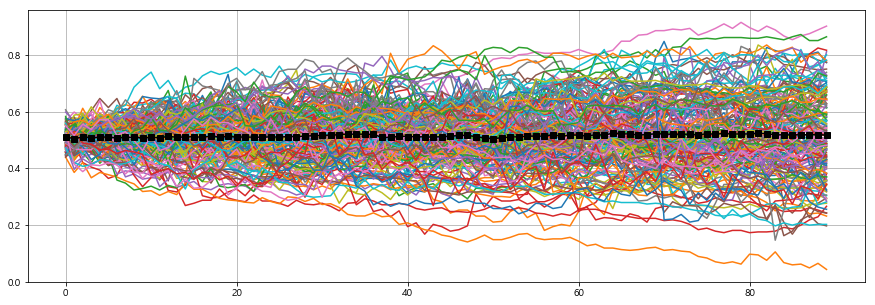

In [45]:
plt.figure(figsize=(15,5))
for stock, res in y1.items():
    plt.plot(res)
plt.plot(pd.DataFrame(y1).mean(1), color='k', marker='s')
plt.grid(True)

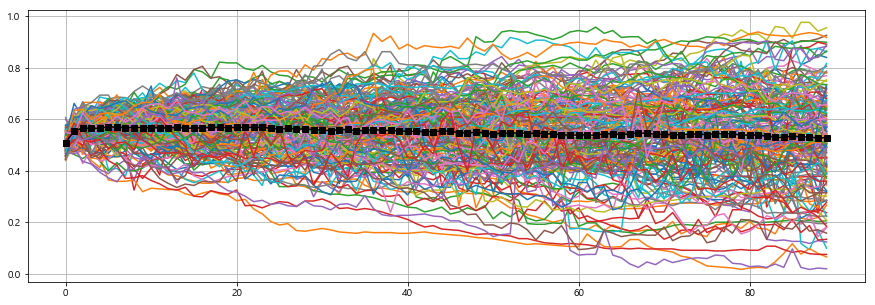

In [47]:
plt.figure(figsize=(15,5))
for stock, res in y2.items():
    plt.plot(res)
plt.plot(pd.DataFrame(y2).mean(1), color='k', marker='s')
plt.grid(True)

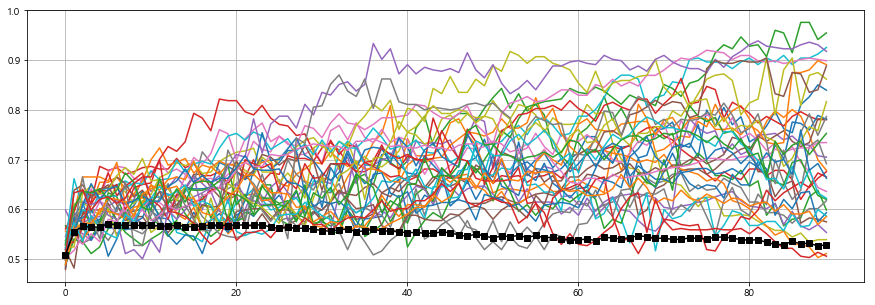

In [75]:
plt.figure(figsize=(15,5))
for stock, r in y2.items():
    if stock not in res.keys():
        continue
    plt.plot(r)
plt.plot(pd.DataFrame(y2).mean(1), color='k', marker='s')
plt.grid(True)

In [69]:
ct = 1
res = {}
for stock, data in y2.items():
    if min(data[10:]) > 0.5:
        res[stock] = (np.argmax(data), max(data))

In [73]:
res.keys()

dict_keys(['AK홀딩스', 'DB손해보험', 'KCC', 'LG디스플레이', 'LG이노텍', 'LG하우시스', 'LS', 'S&T모티브', 'S-Oil', '고려아연', '금호석유', '남양유업', '대덕전자', '대우조선해양', '대한유화', '동국제강', '메리츠종금증권', '빙그레', '세아베스틸', '세아제강', '셀트리온', '신한지주', '에스엘', '에스원', '카카오', '태광산업', '하나금융지주', '한미사이언스', '한섬', '한온시스템', '한일시멘트', '한화', '현대엘리베이', '현대차'])

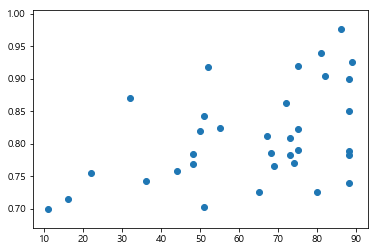

In [72]:
plt.scatter([ix for ix, acc in res.values()], [acc for ix, acc in res.values()])

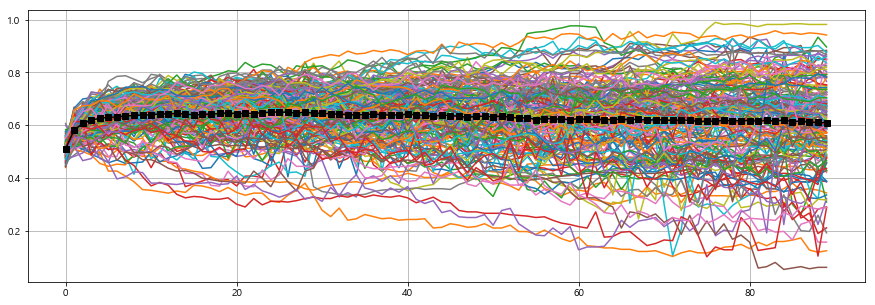

In [49]:
plt.figure(figsize=(15,5))
for stock, res in y3.items():
    plt.plot(res)
plt.plot(pd.DataFrame(y3).mean(1), color='k', marker='s')
plt.grid(True)

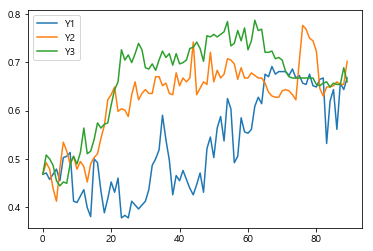

In [353]:
plt.plot([data[1] for key, data in result.items() if key.find('Y1') != -1], label='Y1')
plt.plot([data[1] for key, data in result.items() if key.find('Y2') != -1], label='Y2')
plt.plot([data[1] for key, data in result.items() if key.find('Y3') != -1], label='Y3')
plt.legend()